In [1]:
import requests

url = 'https://raw.githubusercontent.com/Mfys212/dokumen/main/kaggle.json'
destination = '/content/kaggle.json'

response = requests.get(url)
if response.status_code == 200:
  with open(destination, 'wb') as file:
    file.write(response.content)
  print(f'Succes {destination}')
else:
  print(f'Failed: {response.status_code}')

Succes /content/kaggle.json


In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

 95% 27.0M/28.4M [00:00<00:00, 96.7MB/s]
100% 28.4M/28.4M [00:00<00:00, 91.5MB/s]


In [4]:
!unzip fruit-images-for-object-detection.zip

Archive:  fruit-images-for-object-detection.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip/test/apple_87.jpg  
  inflating: test_zip/test/apple_87.xml  
  inflating: test_zip/test/a

In [118]:
!pip install selectivesearch

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xml.etree.ElementTree as ET
from keras.models import Sequential
import keras
from keras.utils import to_categorical
from keras import optimizers, Model
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.applications import VGG16, Xception, DenseNet121, ResNet50V2
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import selectivesearch

In [6]:
s1, s2, s3 = 224, 224, 3
def read_images_and_labels(data_dir):
  images = []
  labels = []

  for file_name in os.listdir(data_dir):
    if file_name.endswith('.xml'):
      xml_path = os.path.join(data_dir, file_name)
      tree = ET.parse(xml_path)
      root = tree.getroot()

      img_filename = root.find('filename').text
      img_path = os.path.join(data_dir, img_filename)

      for obj in root.findall('.//object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        img = cv2.imread(img_path)
        cropped_img = img[ymin:ymax, xmin:xmax]
        image = cv2.resize(cropped_img, (s1, s2))
        images.append(image)
        labels.append(label)

  return images, labels

train_dir = '/content/train_zip/train'
test_dir = '/content/test_zip/test'
train_images, train_labels = read_images_and_labels(train_dir)
test_images, test_labels = read_images_and_labels(test_dir)
train_images, test_images = np.array(train_images), np.array(test_images)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)
labels = np.unique(train_labels)
num_class = len(np.unique(train_labels))
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)
train_labels = to_categorical(train_labels, num_class)
test_labels = to_categorical(test_labels, num_class)
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (465, 224, 224, 3)
Train Labels Shape: (465, 3)
Test Images Shape: (117, 224, 224, 3)
Test Labels Shape: (117, 3)


In [7]:
datagen = ImageDataGenerator(
    rotation_range=40,      # Rentang rotasi gambar
    width_shift_range=0.2,  # Rentang pergeseran horizontal
    height_shift_range=0.2, # Rentang pergeseran vertikal
    shear_range=0.2,        # Rentang pergeseran sudut (shear)
    zoom_range=0.2,         # Rentang zoom
    horizontal_flip=True   # Flip horizontal
)
train_generator = datagen.flow(train_images, train_labels, batch_size=32)

In [8]:
def pretrained_model(pretrained):
  base = pretrained(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in base.layers:
    layer.trainable = False
  return base

def clf_model(pretrained):
  model = Sequential()
  model.add(pretrained_model(pretrained))
  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.Dense(128,activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(64,activation='relu'))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(num_class, activation='softmax'))
  return model

def define_model(pretrained):
  model = clf_model(pretrained)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [9]:
vggmodel = define_model(VGG16)
vggmodel.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0 

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vggmodel.fit(train_generator, epochs=15, batch_size=32, validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/15
15/15 [==============================] - 36s 1s/step - loss: 4.3885 - accuracy: 0.4796 - val_loss: 0.3818 - val_accuracy: 0.8803
Epoch 2/15
15/15 [==============================] - 7s 481ms/step - loss: 1.1564 - accuracy: 0.7527 - val_loss: 0.3384 - val_accuracy: 0.9145
Epoch 3/15
15/15 [==============================] - 6s 415ms/step - loss: 0.6417 - accuracy: 0.8280 - val_loss: 0.3161 - val_accuracy: 0.9316
Epoch 4/15
15/15 [==============================] - 8s 510ms/step - loss: 0.4364 - accuracy: 0.8882 - val_loss: 0.3402 - val_accuracy: 0.9060
Epoch 5/15
15/15 [==============================] - 6s 401ms/step - loss: 0.3684 - accuracy: 0.8925 - val_loss: 0.3568 - val_accuracy: 0.8974
Epoch 6/15
15/15 [==============================] - 6s 429ms/step - loss: 0.3850 - accuracy: 0.9032 - val_loss: 0.2863 - val_accuracy: 0.9145
Epoch 7/15
15/15 [==============================] - 7s 440ms/step - loss: 0.2626 - accuracy: 0.9247 - val_loss: 0.3762 - val_accuracy: 0.9145
Epoch 8/

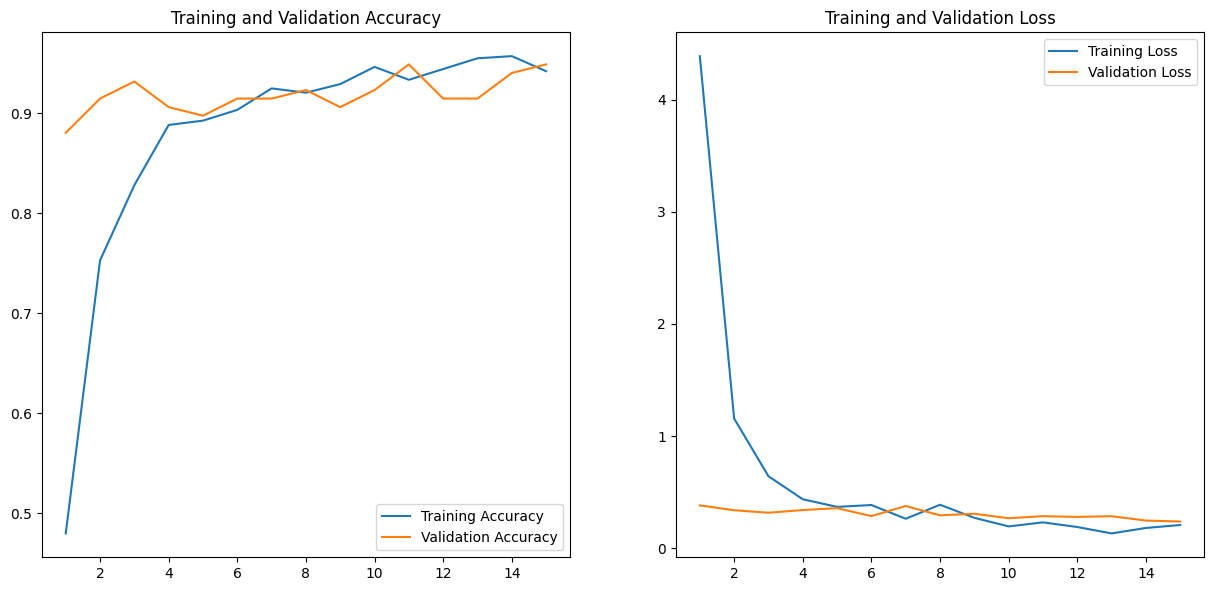

In [11]:
epochs_range = range(1, len(history.epoch)+1)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
def image_predictions(model, img):
  def prediksi(image, model):
    image = cv2.resize(image, (s1, s2))
    img = np.array(image)
    img= np.reshape(img, (1, s1, s2, s3))
    pred = model.predict(img, verbose=0)
    list_kls = list(labels)
    return list_kls[np.argmax(pred[0])]
  print("Predicted:", prediksi(img, model))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Predicted: apple


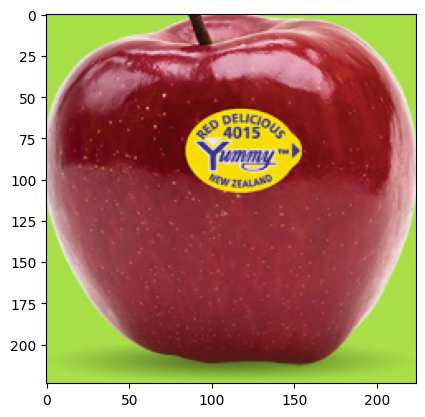

In [13]:
image_predictions(vggmodel, test_images[1])

# RCNN

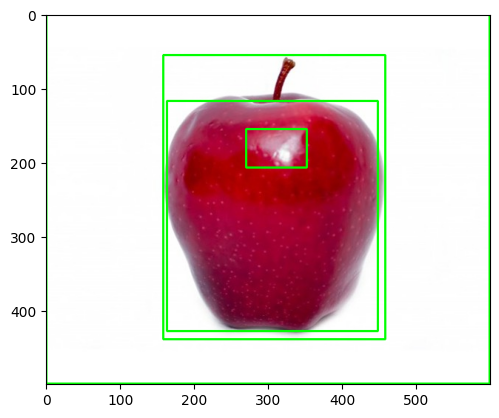

In [209]:
image = cv2.imread('/content/test_zip/test/apple_80.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
_, regions = selectivesearch.selective_search(image_rgb, scale=1000, sigma=0.9, min_size=224)
regions_coordinates = [region['rect'] for region in regions]
proposal, x, y, w, h = [], [], [], [], []
for i in regions_coordinates:
  x, y, w, h = i
  cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [199]:
def selective_search(image_path):
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  _, regions = selectivesearch.selective_search(image_rgb, scale=1000, sigma=0.9, min_size=224)
  regions_coordinates = [region['rect'] for region in regions]
  proposal, x, y, w, h = [], [], [], [], []
  for i in regions_coordinates:
    x_, y_, w_, h_ = i
    c_image = image[y_:y_+h_, x_:x_+w_]
    proposal.append(c_image)
    x.append(x_)
    y.append(y_)
    w.append(w_)
    h.append(h_)
  return proposal, x, y, w, h

In [200]:
def img_predictions(model, im, gray=False):
  def prediksi(image, model):
    image = cv2.resize(image, (s1, s2))
    img = np.array(image)
    img= np.reshape(img, (1, s1, s2, s3))
    plt.imshow(img[0])
    pred = model.predict(img, verbose=0)
    list_kls = list(labels)
    return list_kls[np.argmax(pred[0])], np.max(pred[0])
  return prediksi(im, model)

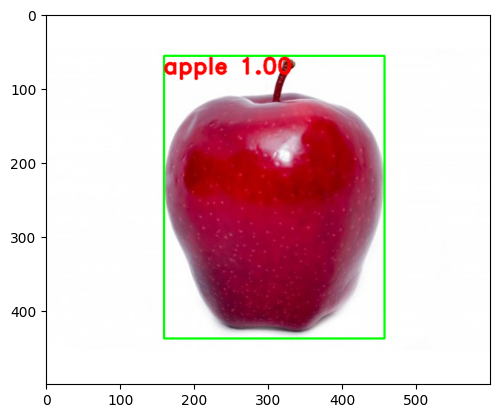

In [201]:
def image_detection(model, image, gray=False):
  img = cv2.imread(image)
  proposal = selective_search(image)
  pred, conf = [], []
  for i in proposal[0]:
    try:
      pr = img_predictions(model, i)
      pred.append(pr[0])
      conf.append(pr[1])
    except:
      continue
  j = conf.index(max(conf))
  if len([x_ for x_ in conf if x_==conf[j]]) > 1:
    b = [w_*h_ for x_,w_,h_ in zip(conf, proposal[3], proposal[4]) if x_==conf[j]]
    while True:
      if max(b) in list(range(round(img.shape[0]*img.shape[1]*0.75), img.shape[0]*img.shape[1]+1000)):
        b.remove(max(b))
      else:
        break
    j = proposal[3].index([w_ for w_,h_ in zip(proposal[3], proposal[4]) if w_*h_ == max(b)][0])
  clas, confi = pred[j], max(conf)
  x, y, w, h = proposal[1][j], proposal[2][j], proposal[3][j], proposal[4][j]
  cv2.rectangle(img, (x+1, y+1), (x+w-1, y+h-1), (0, 255, 0), 2)
  cv2.putText(img, f"{clas} {confi:.2f}", (x, y+w//12), cv2.FONT_HERSHEY_DUPLEX, w / 20 /15, (0, 0, 255), 2, cv2.LINE_AA)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

image_detection(vggmodel, '/content/test_zip/test/apple_80.jpg')

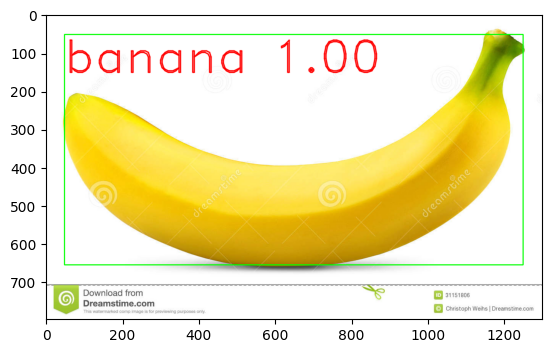

In [202]:
image_detection(vggmodel, '/content/test_zip/test/banana_79.jpg')

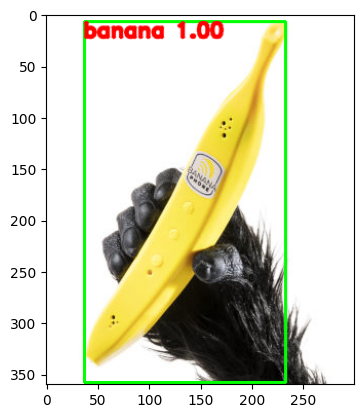

In [203]:
image_detection(vggmodel, '/content/test_zip/test/banana_77.jpg')

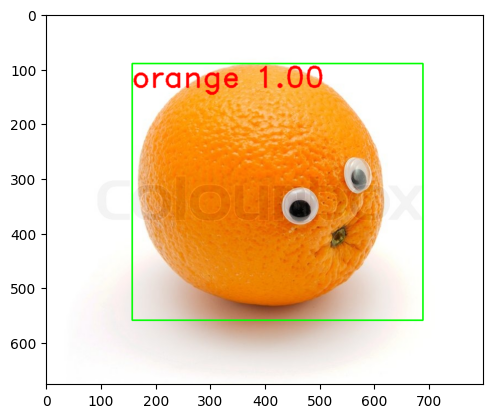

In [204]:
image_detection(vggmodel, '/content/test_zip/test/orange_91.jpg')

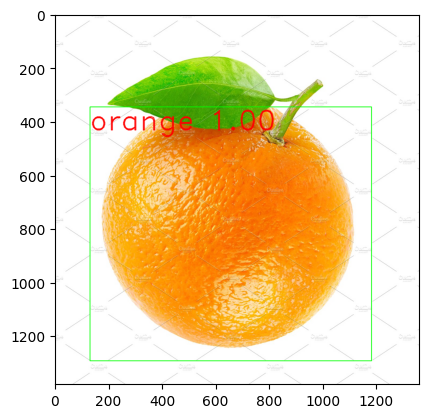

In [214]:
image_detection(vggmodel, '/content/test_zip/test/orange_95.jpg')